In [1]:
%load_ext autoreload
%autoreload 2
from naml.dataset import Datasets, DatasetRemote
datasets = Datasets("~/naml-data")
import re

lines = datasets.fetch(DatasetRemote(
    "timemachine","http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt"
)).readlines()

lines = [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
lines[0], lines[10]

timemachine:   0%|          | 0.00/179k [00:00<?, ?B/s]

('the time machine by h g wells',
 'twinkled and his usually pale face was flushed and animated the')

In [2]:
from naml.text import Vocabulary
tokens = Vocabulary.tokenize_char(lines)
corpus = Vocabulary.to_corpus(tokens)
vocab = Vocabulary(corpus)
print(*zip(vocab.top_tokens[:10],vocab.freqs(vocab.top_tokens[:10])))

(' ', 29927) ('e', 17838) ('t', 13515) ('a', 11704) ('i', 10138) ('n', 9917) ('o', 9758) ('s', 8486) ('h', 8257) ('r', 7674)


## RNN
$$
\mathbf{H_t} = \phi(\mathbf{X_t}\mathbf{W_{xh}} + \mathbf{H_{t-1}}\mathbf{W_{hh}} + \mathbf{b_h}) \\
\mathbf{Y_t} = \mathbf{H_t}\mathbf{W_{ho}} + \mathbf{b_o}
$$
$$
\mathbf{H} = \text{hidden state} \\
\mathbf{X} = \text{input} \\
\mathbf{Y} = \text{output} \\
\mathbf{W_{xh}} = \text{input weight}\ \mathbf{W_{hh}} = \text{hidden weight}\ \mathbf{W_{ho}} = \text{output weight}\ \mathbf{b_h} = \text{hidden bias}\ \mathbf{b_o} = \text{output bias}
$$

In [3]:
from naml.modules import nn, torch

class RNN(nn.Module):
    # GRU for implementation
    def __init__(self, vocab_size, num_hiddens, num_layers):
        super().__init__()
        self.vocab_size, self.num_hiddens, self.num_layers = vocab_size, num_hiddens, num_layers
        self.rnn = nn.GRU(vocab_size, num_hiddens, num_layers)
        self.dense = nn.Linear(num_hiddens, vocab_size)       

    def forward(self, X : torch.Tensor, H : torch.Tensor):
        # X[timestep,batch_size,vocab_size]
        X = nn.functional.one_hot(X.T.long(), self.vocab_size).float()
        Y, H = self.rnn(X, H)
        # Y[timestep,batch_size,num_hiddens]
        Y = Y.reshape(-1, Y.shape[-1])
        # Y[timestep*batch_size,num_hiddens]
        Y = self.dense(Y)        
        return Y, H
    
    def begin_state(self, device : torch.device, batch_size : int):
        return torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device)

device = torch.device('cpu')
net = RNN(len(vocab), 256, 1)
net = net.to(device)
def predict(net, prefix, num_preds):
    H = net.begin_state(device, 1)
    prefix = vocab.tokenize_char([prefix])[0]
    output = [vocab[prefix[0]][0]]
    # Hidden state warmup
    for token in prefix[1:]:
        X = torch.tensor([[output[-1]]], device=device).reshape((1,1))
        Y, H = net(X, H)
        output.append(vocab[token][0])
    # Predictions
    for pred in range(num_preds):
        X = torch.tensor([[output[-1]]], device=device).reshape((1,1))
        Y, H = net(X, H)
        output.append(int(Y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.ivocab[i] for i in output])

predict(net, 'time traveller ', 10)

'time traveller mmwmwwlmmw'

## Perplexity
$$
\text{Perplexity} = \exp\left(-\frac{1}{N}\sum_{i=1}^{N}\log p(x_i)\right),\text {or equivalently} \ \exp(\text{nn.CrossEntropyLoss}\ \text{with mean reduction})
$$


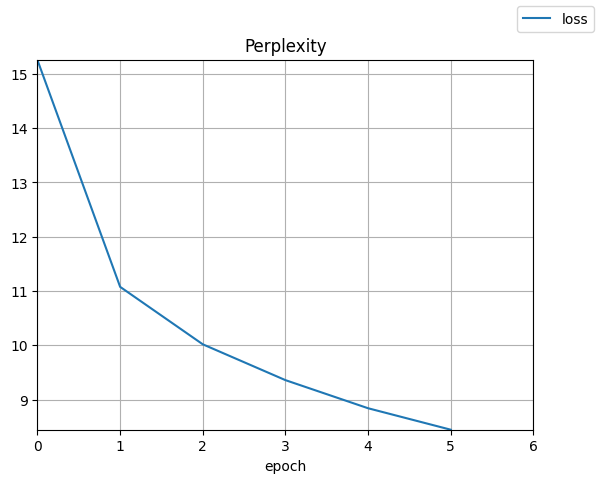

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

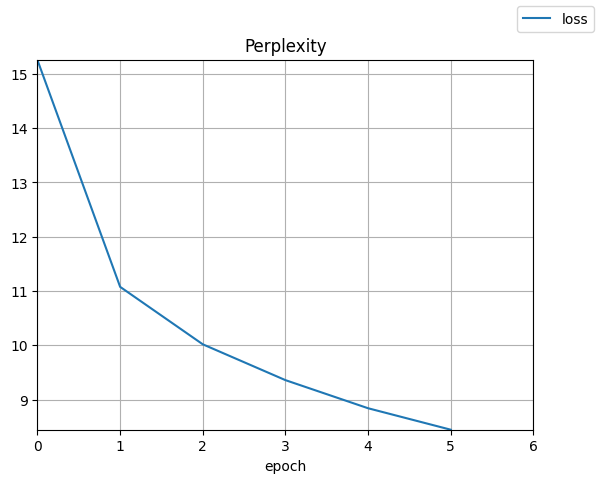

In [4]:
import math
from naml.plot import tqdm
from naml.sequence import seq_partition_sample_sequential
from naml.util import run_epochs
corpus_indices = vocab.to_indices(corpus)

batch_size, num_steps = 32, 35

net = RNN(len(vocab), 256, 1)
net = net.to(device)
# XXX: Grad clipping
def train(net, lr, num_epochs):
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(net.parameters(), lr=lr)
    @run_epochs("Perplexity")
    def train_epoch():
        H = net.begin_state(device, batch_size)                
        loss_sum, count = 0, 0
        train_iter = seq_partition_sample_sequential(corpus_indices, batch_size, num_steps)
        for X, Y in train_iter:
            H.detach_() # Why?
    
            y = Y.T.reshape(-1) # [batch_1_step_1, batch_2_step_1, ...]
            X = X.to(device)        
            y = y.to(device)
            Y_hat, H = net(X, H)
            l = loss(Y_hat, y.long()).mean()
            optim.zero_grad()
            l.backward()
            optim.step()        
            loss_sum += l.detach() * y.numel()
            count += y.numel()
        print(predict(net, "time", 50), end='\r')
        return math.exp(loss_sum/count)
    train_epoch(num_epochs)

train(net, 1, 500)